In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Liberation Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
import sys
sys.path.insert(0, './python')

from windkessel import model

In [3]:
from scipy.integrate import solve_ivp

In [4]:
test_model = model.WindkesselModel()
test_model.R.data   = torch.ones(1, dtype=torch.float64) * 870
test_model.Z_0.data = torch.ones(1, dtype=torch.float64) * 0
test_model.C.data   = torch.ones(1, dtype=torch.float64) * 1e-3
test_model.P_out.data   = torch.ones(1, dtype=torch.float64) * 0

In [5]:
def P_rhs(t, P):
    return test_model.P_rhs(t, P).detach().numpy()

In [18]:
def article_Q_LA(t, T_max = 0.09, T_S = 0.33, t_d = 0.35, T = 0.9, Q_max = 0.37, C_sa = 1e-3, R_S = 870, R_f = 0.3):
    while t < 0:
        t += T
    while t > T:
        t -= T
    if 0 <= t and t <= T_max:
        return 0.5 * Q_max * (np.sin(np.pi * (t - T_max / 2) / T_max) + 1)
    elif T_max <= t and t <= T_S:
        return 0.5 * Q_max * (np.cos(np.pi * (t - T_max) / (T_S - T_max)) + 1)
    elif T_S <= t and t <= T:
        return 0.0
    
def article_Q(t, T_max = 0.09, T_S = 0.33, t_d = 0.35, T = 0.9, Q_max = 0.37, C_sa = 1e-3, R_S = 870, R_f = 0.3):
    ans = article_Q_LA(t) + R_f * article_Q_LA(t - t_d)
    return ans

T = np.linspace(0, 20, 1000)
Q = np.zeros_like(T)
for i in range(len(Q)):
    Q[i] = article_Q(T[i])
    
test_model.set_Q_in(T, Q)

In [19]:
result = solve_ivp(P_rhs, (T[0], T[-1]), np.array([66.0]), t_eval = T)

In [20]:
P = result.y[0]

In [21]:
def plot_x_y(x, y):
    fig = plt.figure()
    ax = fig.gca()
    fig.set_figheight(12)
    fig.set_figwidth(16)
    ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
    ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')
    
    ax.plot(x,y)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

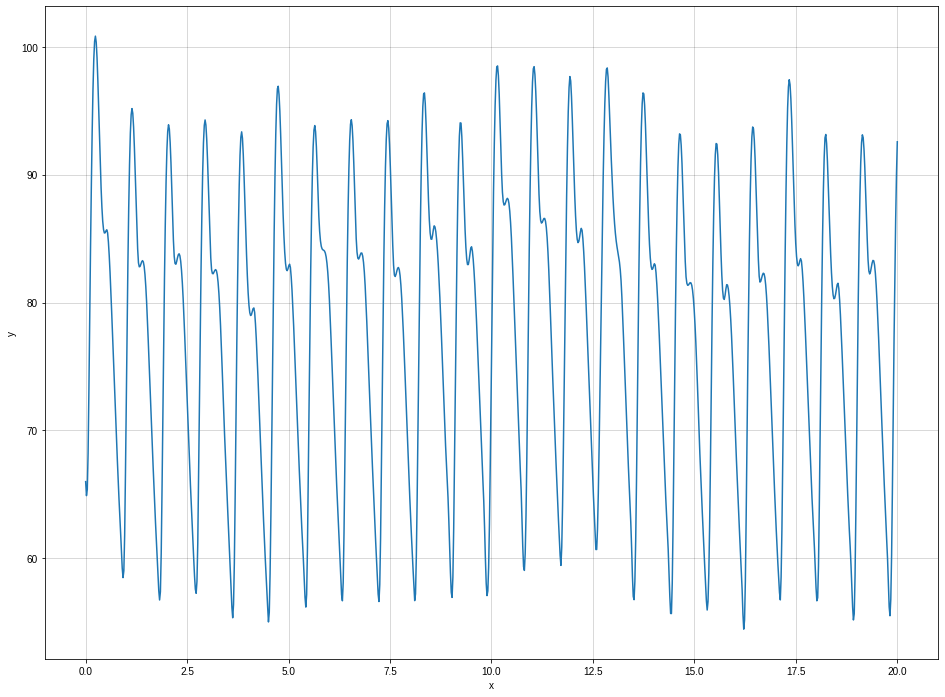

In [22]:
plot_x_y(T, P)